In [ ]:
from stock.transformer import StdNormalize, AmountVocab

import pandas as pd
import numpy as np
import tqdm


df = pd.read_csv("./daily/stock_2024-12-26.csv")
cdf = pd.read_csv("stock_today.csv")
fdf = pd.read_csv("./daily/stock_fund_2024-12-26.csv")
cfdf = pd.read_csv("stock_fund_today.csv")
fdf = pd.concat([fdf,cfdf])
df = pd.concat([df,cdf])
df = df.merge(fdf)
df.dropna(inplace=True)
vnor, snor, mnor= StdNormalize(gap=5.0),StdNormalize(gap=10.0),StdNormalize(gap=25.0)
avocab = AmountVocab(df["amount"].values)
mvocab = AmountVocab(df["main_amount"].values)

def nor_feature(r,p,pg):
    amount, price  = pg["amount"].mean(), pg["close"].mean()
    price_max, price_min = pg["close"].max(), pg["close"].min()
    amount_max, amount_min = pg["amount"].max(), pg["amount"].min()
    close = snor((r.close - p.close)*100/p.close)
    _open = snor((r.open - p.close)*100/p.close)
    high = snor((r.high - p.close)*100/p.close)
    low = snor((r.low - p.close)*100/p.close)
    plow =snor((r.low - price_min)*100/price)
    phigh =snor((r.high - price_max)*100/price)
    pclose =snor((r.close - price)*100/price)
    volume = vnor(np.log2(r.amount/amount))
    vhigh = vnor(np.log2(r.amount/amount_max))
    vlow = vnor(np.log2(r.amount/amount_max))
    amount = avocab(r.amount)/10
    mamount = mvocab(r.main_amount)/10
    mpercent =mnor(r.main_percent)
    # [close,_open,high,low,volume,amount,plow,phigh, pclose,vhigh,vlow]

    return [close,_open,high,low,volume,amount,mamount, mpercent]

def make_data(df, cdate, cnum):
    codes, names, targets, features = [], [], [],[]
    for k,g in tqdm.tqdm(df.sort_values(by="date", ascending=False).groupby("code"),
                         desc=f"processing date[{cdate}]"):
        cur = g[g.date==cdate]
        g = g[g.date<cdate]
        cg, pg = g[:cnum],g[cnum:]
        row = np.zeros((cnum,8),dtype=float)
        if cg.shape[0]==cnum and pg.shape[0]>0 and cur.shape[0]>0:
            cr,pr = cur.iloc[0],cg.iloc[0]
            codes.append(cr["code"])
            names.append(cr["name"])
            change = (cr.close-pr.close)*100/pr.close
            if change>10:
                change = 10
            elif change<-10:
                change = -10
            targets.append(change/10.0)
            for i in range(cg.shape[0]):
                r, p= g.iloc[i],g.iloc[i+1]
                row[i,:] = nor_feature(r,p,pg)
            features.append(row)
        # break
    return pd.DataFrame({"date":cdate, "code":codes,"name":names,"feature":features, "target": targets})

pdf = make_data(df, "2024-12-25", 10)
cdf = make_data(df, "2024-12-26", 10)
pdf.head()


processing date[2024-12-25]:   4%|▍         | 194/4410 [00:04<01:23, 50.75it/s]


In [30]:
import warnings
warnings.filterwarnings("ignore")
import torch
from torch import nn
from torch.nn import functional as F
import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from torch.utils.data import DataLoader, random_split, Dataset
from lightning.pytorch.loggers import CSVLogger
logger = CSVLogger("logs", name="my_exp_name")



class StockDataset(Dataset):
    def __init__(self, df):
        self.df = df
    def __len__(self):
        return self.df.shape[0]
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        return (torch.tensor(row["feature"], dtype=torch.float32),
                torch.tensor([row["target"]],dtype=torch.float32))

class DailyGRU(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.rnn = nn.GRU(8, 64,num_layers=2, batch_first=True, bidirectional=False)
        self.linear = nn.Linear(2*64, 1)

    def forward(self, x):
        bs,length  = x.shape[0], x.shape[1]
        x = x.view((bs,length,-1))
        output, hn= self.rnn(x)
        y = hn.view((bs,-1))
        y = torch.relu(y)
        ouputs = self.linear(y)
        ouputs = torch.tanh(ouputs)
        return ouputs

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        x, y = batch
        return self.forward(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.forward(x)
        # print(x_hat.shape,y.shape)
        loss = F.mse_loss(x_hat, y)
        self.log("train_loss", loss)

    def validation_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, y)
        self.log("val_loss", loss,prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x_hat, y)
        self.log("test_loss", loss)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return optimizer

model = DailyGRU()
valid_len = int(pdf.shape[0]*0.1)
train_dataset, valid_dataset = random_split(StockDataset(pdf), [len(pdf)-valid_len,valid_len])
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=32,shuffle=False)
test_loader = DataLoader(StockDataset(cdf),batch_size=32,shuffle=False)
callbacks=[EarlyStopping(monitor="val_loss", mode="min",patience=3)]
trainer = L.Trainer(limit_train_batches=100, max_epochs=5, callbacks=callbacks, logger=logger)
trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=valid_loader)
trainer.test(model=model, dataloaders = test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/my_exp_name

  | Name   | Type   | Params
----------------------------------
0 | rnn    | GRU    | 39.2 K
1 | linear | Linear | 129   
----------------------------------
39.3 K    Trainable params
0         Non-trainable params
39.3 K    Total params
0.157     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.10081607103347778    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.10081607103347778}]

In [31]:
predictions = trainer.predict(model, test_loader)
cdf["prediction"] = torch.concat(predictions)*10
cdf.sort_values(by="prediction",ascending=False)[:20]

Predicting: |          | 0/? [00:00<?, ?it/s]

,date,code,name,feature,target,pred,prediction
66,2024-12-26,sh600096,云天化,"[[0.0, -0.0044033465433736515, 0.0572435050638...",-0.092470,0.019165,-0.430112
1419,2024-12-26,sh603790,雅运股份,"[[-0.35744680851063826, -0.08510638297872311, ...",0.167696,0.020689,-0.447726
261,2024-12-26,sh600359,新农开发,"[[-0.27863777089783237, 0.0, 0.046439628482972...",0.222930,-0.006478,-0.464758
2793,2024-12-26,sz002736,国信证券,"[[-0.09590235396687115, -0.017436791630341196,...",0.008803,-0.020718,-0.468437
65,2024-12-26,sh600095,湘财股份,"[[-0.13037809647979093, -0.026075619295957725,...",0.052840,0.026440,-0.473566
1351,2024-12-26,sh603662,柯力传感,"[[-0.473653901526057, -0.08206161819752278, 0....",0.352123,0.021117,-0.490198
3566,2024-12-26,sz300561,汇金科技,"[[-0.5257689110556929, -0.36990856192851085, 0...",0.094319,0.012131,-0.516282
196,2024-12-26,sh600266,城建发展,"[[0.08064516129032265, 0.020161290322580218, 0...",0.000000,-0.015505,-0.517456
2724,2024-12-26,sz002655,共达电声,"[[-0.08988764044943762, -0.07490636704119824, ...",0.355253,0.005231,-0.523733
1124,2024-12-26,sh603208,江山欧派,"[[-0.02157497303128325, 0.02157497303128325, 0...",0.048649,-0.014847,-0.526385


MSE is: 10.08
The Pearson Correlation Coefficient is:0.03


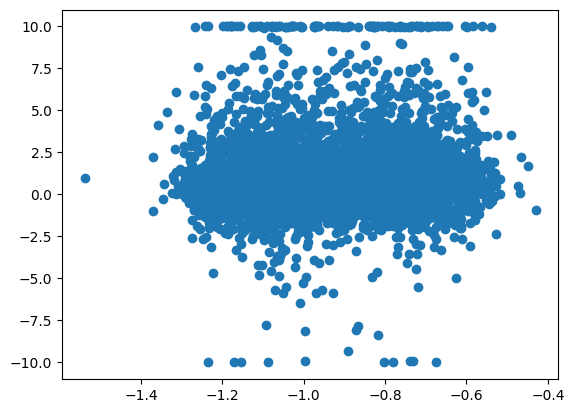

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error

smse = mean_squared_error(cdf["prediction"], cdf["target"]*10)
print(f"MSE is: {smse:.2f}")
pr = pearsonr(cdf["prediction"], cdf["target"]*10)[0]
print(f"The Pearson Correlation Coefficient is:{pr:.2f}")
plt.scatter(cdf["prediction"], cdf["target"]*10)
plt.show()

In [24]:
L.__version__

'2.1.3'